In [1]:
import sys
sys.path.insert(1, '..')
from utils import *

%matplotlib inline

In [2]:
with open(join('..', '..', 'config.yml')) as f:
    config = yaml.safe_load(f)
    
pwd = config['pwd']
dpath = config['storage']
patterns = config['pattern-data-path']
util_datasets = config['util_datasets']
datasets = config['datasets']
colors = config['colors']

FIG_SAVE_DIR = join(pwd, 'figures')
RESULT_SAVE_DIR = join(pwd, 'results')

AREA_NAME = 'NYC'
network_dir = join(pwd, dpath, 'mobility-networks', f'{AREA_NAME}-CBG-CBG-Nets-msa')
nets = load_networks(network_dir)

100%|████████████████████████████████████████████████████████████████████████████████| 107/107 [00:54<00:00,  1.95it/s]


In [3]:
msa_counties = pd.read_csv(join(pwd, util_datasets, AREA_NAME, datasets['nyc-msa']))['fips'].astype(np.int64)

In [4]:
census_data = join(pwd, util_datasets, datasets['census-data'])
census_quartiles, census_raw = get_census_attributes(census_data, msa_counties)

In [5]:
device_counts = pd.read_csv(join(pwd, util_datasets, 'ny-msa-device-counts.csv'))
device_counts = device_counts[(device_counts.census_block_group // 10**7).isin(nyc_fips2borough)]
device_counts['date_range_start'] = pd.to_datetime(device_counts['date_range_start'].apply(lambda x: x.split('T')[0]))

In [6]:
timely_population = device_counts.groupby(['date_range_start', device_counts.census_block_group.apply(lambda x: nyc_fips2borough[x//10**7])])['number_devices_residing'].sum()

In [7]:
census_raw['county_fips'] = census_raw.census_block_group // 10**7
nyc_census = census_raw[census_raw.county_fips.isin(nyc_fips2borough)]
# borough populations
b2p = nyc_census.groupby(nyc_census.county_fips.apply(lambda x: nyc_fips2borough[x]))['total_population'].sum()

In [15]:
wattr = 'visits'
raw_mobility_values = []
for net_pair in tqdm(nets):
    date = net_pair[0]
    net = net_pair[1]
    
    for bcode, bname in nyc_fips2borough.items():
        str_bcode = str(bcode)
        borough_nodes = net.vs.select(lambda x: x['name'][:5] == str_bcode)['name']
        other_borough_nodes = net.vs.select(lambda x: x['name'][:5] != str_bcode)['name']
        
        total_outflow = np.sum(net.strength(borough_nodes, mode='out', weights=wattr, loops=True))
        total_inflow = np.sum(net.strength(borough_nodes, mode='in', weights=wattr, loops=True))
        
        bn_set = set(borough_nodes)
        obn_set = set(other_borough_nodes)
        
        row = {
            'borough': bname,
            'date': date,
            'total_outflow': total_outflow,
            'total_inflow': total_inflow,
            'visits_inside_home_borough': np.sum(net.es.select(lambda x: (x.source_vertex['name'] in bn_set) and (x.target_vertex['name'] in bn_set))[wattr]),
            'visits_from_outside_home_borough': np.sum(net.es.select(lambda x: (x.source_vertex['name'] in obn_set) and (x.target_vertex['name'] in bn_set))[wattr]),
            'visits_to_outside_boroughs': np.sum(net.es.select(lambda x: (x.source_vertex['name'] in bn_set) and (x.target_vertex['name'] in obn_set))[wattr])
        }
        raw_mobility_values.append(row)
    
mobility_df = pd.DataFrame(raw_mobility_values)
mobility_df.head()

100%|████████████████████████████████████████████████████████████████████████████████| 107/107 [09:13<00:00,  5.17s/it]


,borough,date,total_outflow,total_inflow,visits_inside_home_borough,visits_from_outside_home_borough,visits_to_outside_boroughs
0,Staten Island,2018-12-31,227623.0,179495.0,161205,18290,66418
1,Manhattan,2018-12-31,492342.0,935079.0,388459,546620,103883
2,Bronx,2018-12-31,482385.0,407583.0,309345,98238,173040
3,Queens,2018-12-31,809229.0,736486.0,532517,203969,276712
4,Brooklyn,2018-12-31,829632.0,761865.0,590804,171061,238828


In [16]:
mobility_df.to_csv(join(pwd, util_datasets, AREA_NAME, datasets['nyc-mobility-by-borough']), index=False)

In [8]:
mobility_df = pd.read_csv(join(pwd, util_datasets, AREA_NAME, datasets['nyc-mobility-by-borough']))
mobility_df.date = pd.to_datetime(mobility_df.date)

In [9]:
for c in mobility_df.columns[2:]:
    #mobility_df[c] = mobility_df.apply(lambda x: x[c]/b2p[x['borough']], axis=1)
    mobility_df[c] = mobility_df.apply(lambda x: x[c]/timely_population.loc[(x['date'], x['borough'])], axis=1)

In [10]:
mobility_df['outside_borough_visit_ratio'] = mobility_df['visits_to_outside_boroughs'] / mobility_df['total_outflow']
mobility_df['In-Out_flow_ratio'] = mobility_df['total_inflow'] / mobility_df['total_outflow']

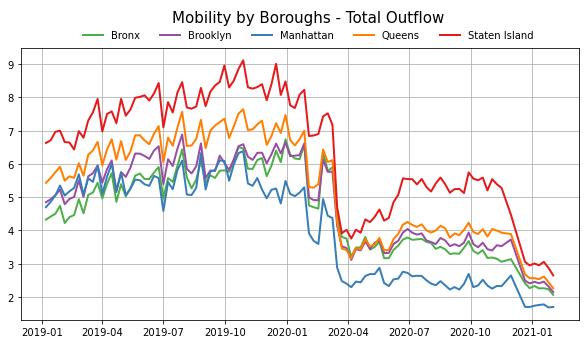

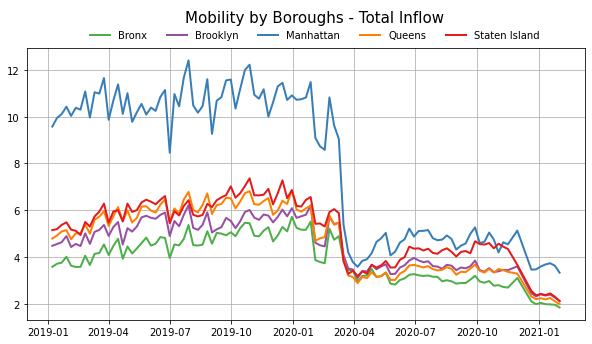

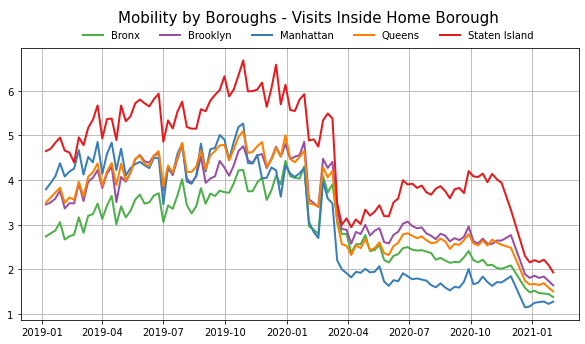

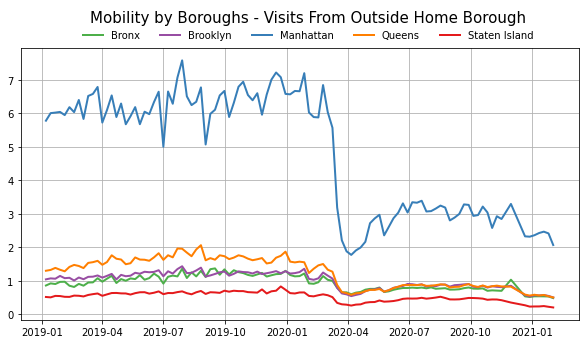

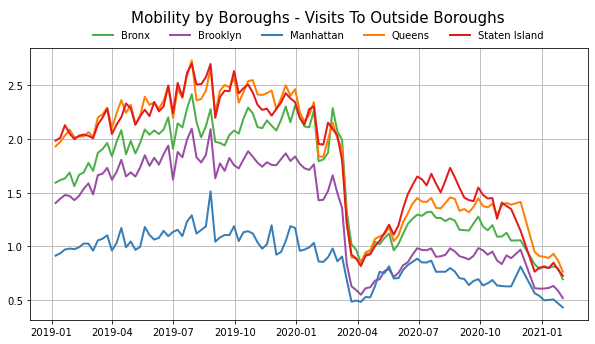

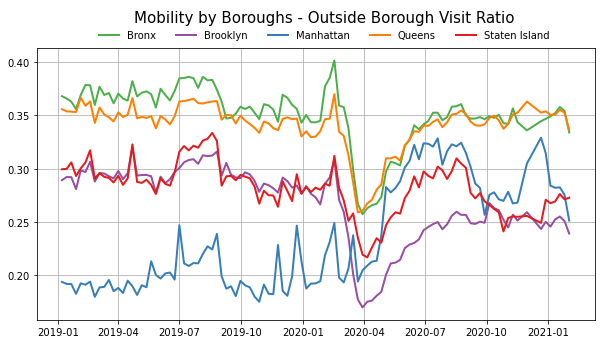

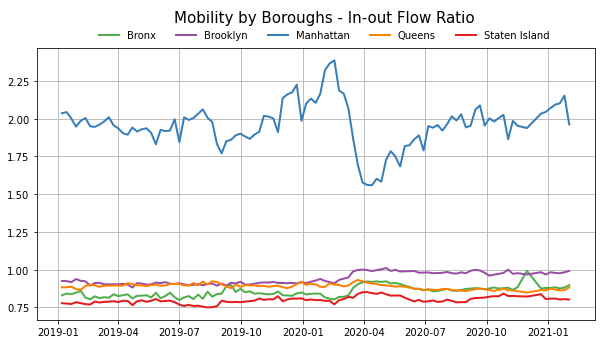

In [12]:
borough_colors = {
    'Staten Island': '#e41a1c',
    'Manhattan': '#377eb8',
    'Bronx': '#4daf4a',
    'Brooklyn': '#984ea3',
    'Queens': '#ff7f00'
}

for vfocus in mobility_df.columns[2:]:
    fig, ax = plt.subplots(1,1,figsize=(10, 5))
    # get values in 2020
    sdate = datetime(2019, 1, 1)

    for borough, ind in mobility_df.loc[mobility_df.date >= sdate].groupby('borough').groups.items():
        v = mobility_df.loc[ind][['date', vfocus]].set_index('date')
        ax.plot(v.index, v.values, label=borough, color=borough_colors[borough], linewidth=2)

    ax.grid()
    tvar = ' '.join([i.capitalize() for i in vfocus.split('_')])
    fig.legend(ncol=5, bbox_to_anchor=(0.85, 1.01), edgecolor='white', title=f'Mobility by Boroughs - {tvar}', title_fontsize=15)
    fig.savefig(join(FIG_SAVE_DIR, f'norm-mobility-boroughs-{vfocus}.pdf'), dpi=900)

In [11]:
def get_quart_cbgs(col, quart, df):
    '''
    get cbgs in the `quart` quartile in col attribute
    '''
    return set(df[df[f'{col}-quartile'] == quart]['census_block_group'].values.astype(str))

if 'county_fips' in nyc_census.columns:
    nyc_census = nyc_census.drop('county_fips', axis=1)
    
quart = ['Bottom', 'Third', 'Second', 'Top']
for col in nyc_census.columns[1:]:
    nyc_census[f'{col}-quartile'] = pd.qcut(nyc_census[col], q=4, labels=[f'{quart[i]}' for i in range(4)])

In [55]:
tdate = datetime(2019, 12, 24)
tnets = nets[nets[:, 0] >= tdate]
dx = [i[0] for i in tnets]

quarts = ['Bottom', 'Top']#['Bottom', 'Third', 'Second', 'Top']
sel_cols = ['education'] #'white_population', 'income', 'black_population', 'asian_population', 'hispanic_population', 'education', 'mean_time_to_work']

cent_metrics = [
        #('Closeness', ig.Graph.closeness, {'cutoff': 3, 'normalized': True, 'weights': None}), 
        ('Betweenness', ig.Graph.betweenness, {'cutoff': 3, 'directed': True, 'weights': None}), 
        #('Eigenvector', ig.Graph.eigenvector_centrality, {'directed': True, 'scale': True}),
        ('In-Degree', 'in', None),
        ('Out-Degree', 'out', None),
        ('Total-Degree', 'all', None),
        ('Self-Visit-Ratio', 'self', None)
    ]

results = []
for tp in tqdm(tnets):
    date = tp[0]
    tnet = tp[1]
    nnodes = len(tnet.vs)
    #norm = (nnodes-1)*(nnodes-2)
    norm = nnodes**2
    for cent_metric_name, metric, params in cent_metrics:
        if not isinstance(metric, str) and params:
            values = np.array(metric(tnet, **params))
            if cent_metric_name == 'Betweenness':
                values /= norm
        elif isinstance(metric, str) and not params:
            if metric != 'self':
                values = np.array(tnet.strength(loops=False, mode=metric, weights='visits'))
            else:
                self_visits = np.subtract(tnet.strength(loops=True, mode='in', weights='visits'), tnet.strength(mode='in', loops=False, weights='visits'))
                out_visits = np.array(tnet.strength(loops=False, mode='out', weights='visits'))
                total_visits = self_visits + out_visits + 0.001

                values = self_visits/total_visits

        data = {
            'date': date,
            'cent_name': cent_metric_name,
            'value': np.mean(values)
        }
        
        for col in sel_cols:
            for quart in quarts:
                cbgs = get_quart_cbgs(col, quart, nyc_census)
                ind = [i for i, v in enumerate(tnet.vs['name']) if v in cbgs]
                data[f'{col}-{quart}'] = np.mean(values[ind])
                lower, upper = bootstrap_ci(values[ind])
                data[f'{col}-{quart}-lower'] = lower
                data[f'{col}-{quart}-upper'] = upper
                
                
        results.append(data)
        
res = pd.DataFrame(results)

100%|██████████████████████████████████████████████████████████████████████████████████| 55/55 [30:14<00:00, 32.99s/it]


In [24]:
res.to_csv(join(pwd, util_datasets, 'change-education.csv'), index=False)

In [12]:
res = pd.read_csv(join(pwd, util_datasets, 'change-education.csv'))
res.date = pd.to_datetime(res.date)

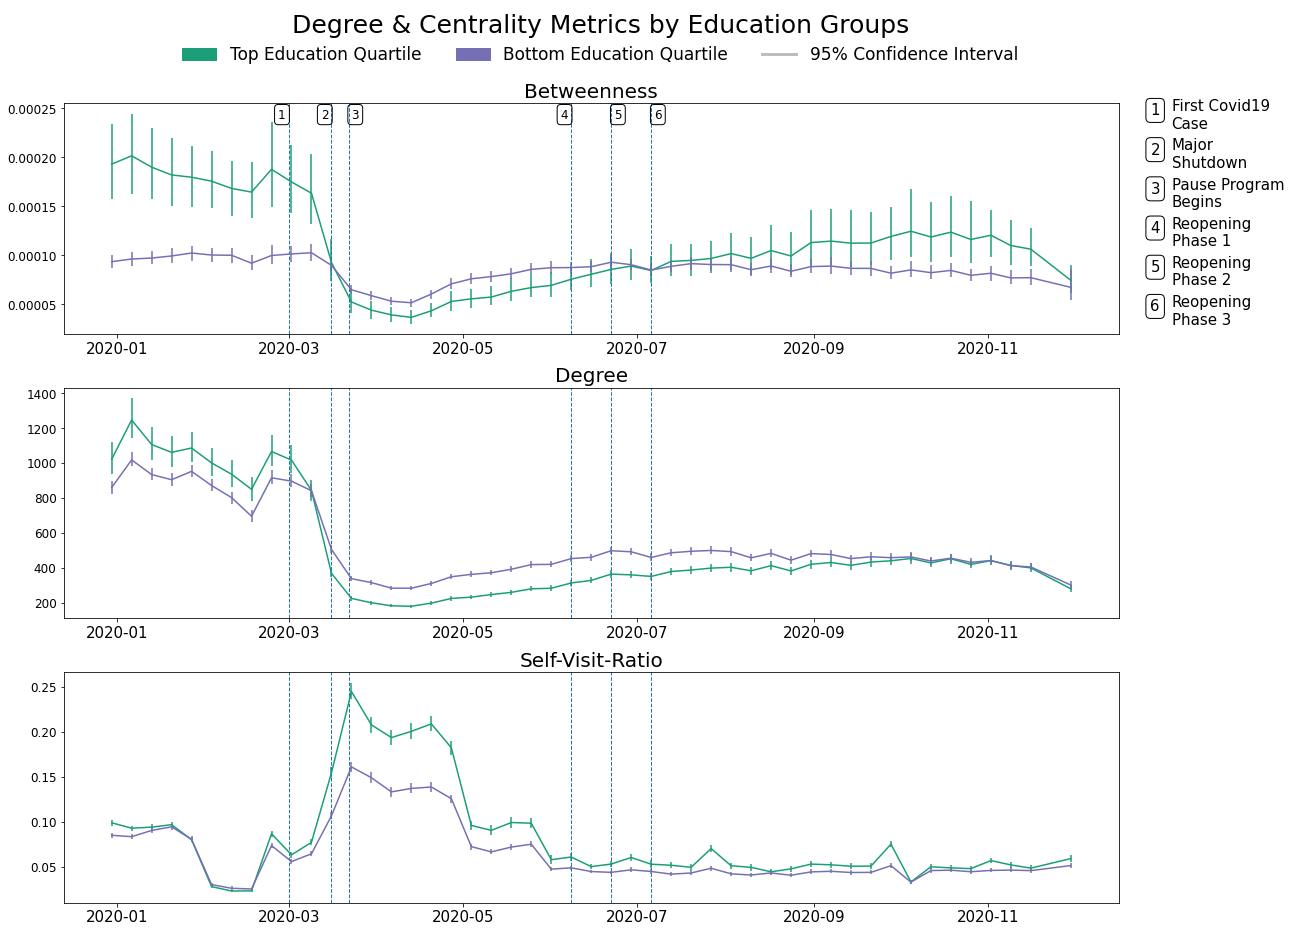

In [78]:
attrs = ['education']
atutil_datasetsame = ['Education']
quarts = ['Bottom', 'Top']
fdate = datetime(2020, 12, 1)

cent_metrics = [
        ('Betweenness', ig.Graph.betweenness, {'cutoff': 3, 'directed': True, 'weights': None}), 
        #('Out-Degree', 'out', None),
        ('Total-Degree', 'out', None),
        ('Self-Visit-Ratio', 'self', None)
    ]

timeline = [
    ("2020-03-01", "First Covid19\nCase", 0.00024, "right", '1'),
    ("2020-03-16", "Major\nShutdown", 0.00024, "right", '2'),
    ("2020-03-22", "Pause Program\nBegins", 0.00024, "left", '3'),
    ("2020-06-08", "Reopening\nPhase 1", 0.00024, "right", '4'),
    ("2020-06-22", "Reopening\nPhase 2", 0.00024, "left", '5'),
    ("2020-07-06", "Reopening\nPhase 3", 0.00024, "left", '6'),
]

fig, axes = plt.subplots(3, 1, figsize=(18, 12))

for ind, (cent_metric_name, metric, params) in enumerate(cent_metrics):
    ax = axes[ind]
    selr = res[res['cent_name'] == cent_metric_name].set_index('date')
    selr = selr.loc[selr.index < fdate]
    xdate = selr.index
    
    top_values = selr['education-Top'].values
    top_values_upper = selr['education-Top-lower'].values
    top_values_lower = selr['education-Top-upper'].values
    
    ax.errorbar(xdate, top_values, yerr=[top_values - top_values_lower, top_values_upper - top_values], color=colors['top_color'])
    #ax.plot(xdate, top_values)
    #ax.fill_between(xdate, top_values_lower, top_values_upper, color=colors['top_color'], alpha=0.5)
    
    bottom_values = selr['education-Bottom'].values
    bottom_values_upper = selr['education-Bottom-lower'].values
    bottom_values_lower = selr['education-Bottom-upper'].values
    
    ax.errorbar(xdate, bottom_values, yerr=[bottom_values - bottom_values_lower, bottom_values_upper - bottom_values], color=colors['bottom_color'])
    #ax.fill_between(xdate, bottom_values_lower, bottom_values_upper, color=colors['bottom_color'], alpha=0.5)
    
    ax.set_xlabel(None)
    plt.setp(ax.xaxis.get_majorticklabels(), ha='center')
    ax.xaxis.set_tick_params(labelsize=15)
    ax.yaxis.set_tick_params(labelsize=12)
    #ax.grid(color='grey', alpha=0.3)
    
    for tindex, (d, s, h, r, n) in enumerate(timeline):
        ax.axvline(datetime.strptime(d, '%Y-%m-%d'), linestyle='--', linewidth=1)
        dt = 1
        if r == 'left':
            dt = -1
        
        if ind == 0:
            ax.text(datetime.strptime(d, "%Y-%m-%d") - timedelta(days=dt), h, n, {"fontsize": 12}, 
                    horizontalalignment=r, bbox=dict(edgecolor='black', fill=False, boxstyle='round'))
            ax.annotate(n, xy=(1.03, 0.95 - tindex * 0.17), fontsize=15, xycoords='axes fraction', bbox=dict(edgecolor='black', fill=False, boxstyle='round'))
            ax.annotate(s, xy=(1.05, 0.95 - tindex * 0.17), fontsize=15, xycoords='axes fraction', verticalalignment='center')
    
    if cent_metric_name == 'Total-Degree':
        ax.set_title('Degree', fontsize=20)#, weight='bold')
    else:
        ax.set_title(cent_metric_name, fontsize=20)#, weight='bold')
        
#     ax.annotate(chr(ord('A') + ind), xy=(-0.01, 1.05), xycoords='axes fraction', bbox=dict(boxstyle="round,pad=0.2", fc="#ffffff", ec="#000000", lw=1),
#                 fontsize=30, horizontalalignment='right', verticalalignment='bottom')

top_patch = mpatches.Patch(color=colors['top_color'])
bottom_patch = mpatches.Patch(color=colors['bottom_color'])
ci_line = Line2D([0], [0], color='#bdbdbd', linewidth=3, linestyle='-')
    
fig.legend([top_patch, bottom_patch, ci_line],
            ['Top Education Quartile', 
             'Bottom Education Quartile',
             '95% Confidence Interval'],
            bbox_to_anchor=(0.80, 1.085), ncol=3, title='Degree & Centrality Metrics by Education Groups', edgecolor='white', fontsize=17, title_fontsize=25)

plt.tight_layout()
fig.savefig(join(FIG_SAVE_DIR, 'education-degree-change-msa-ONLY-NYC.pdf'), dpi=150, bbox_inches='tight')

In [80]:
res = pd.read_csv(join(pwd, util_datasets, 'change.csv'))
res.date = pd.to_datetime(res.date)

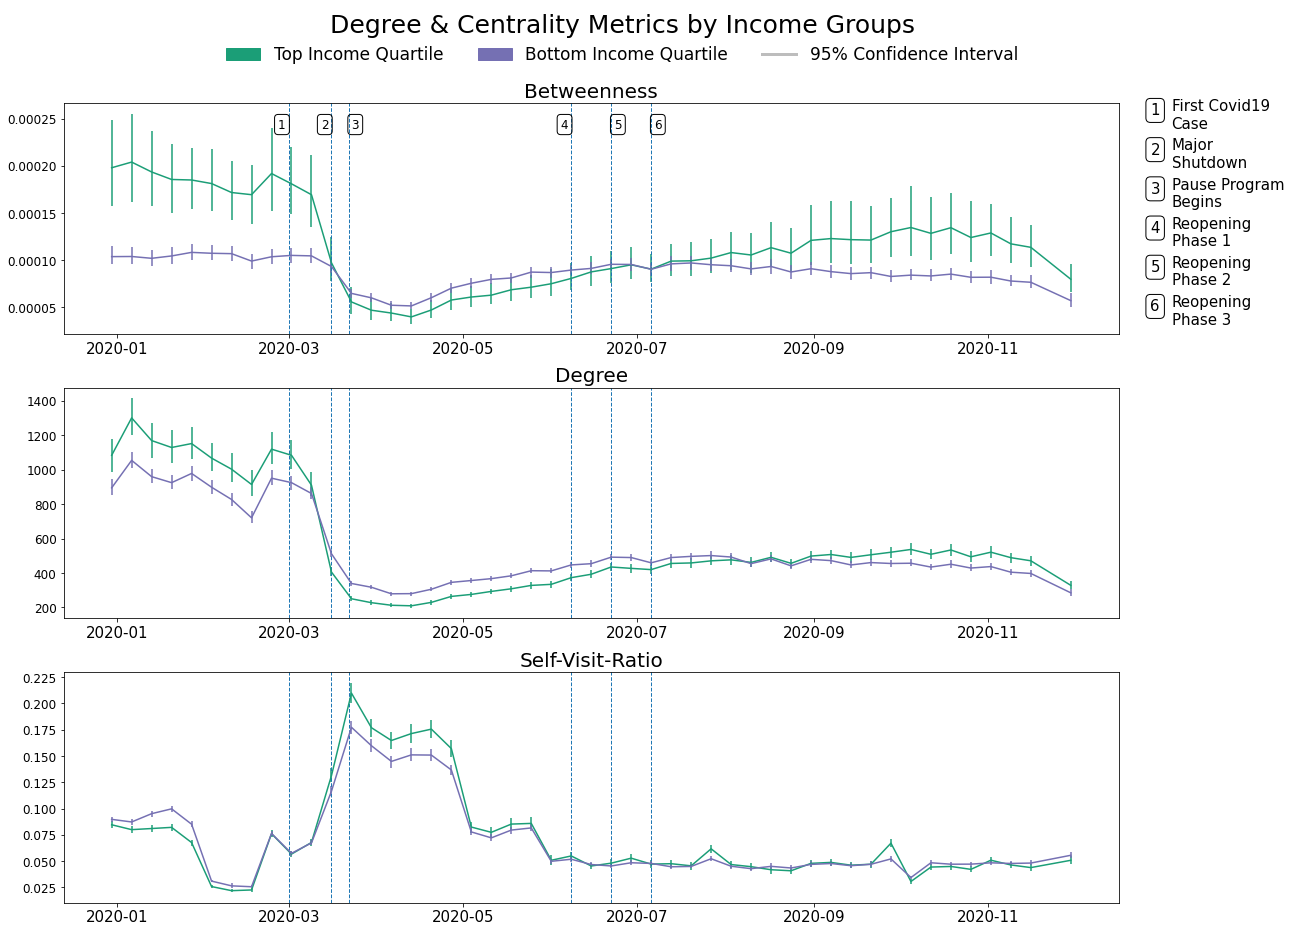

In [85]:
attrs = ['income']
atutil_datasetsame = ['Income']
quarts = ['Bottom', 'Top']
fdate = datetime(2020, 12, 1)

cent_metrics = [
        ('Betweenness', ig.Graph.betweenness, {'cutoff': 3, 'directed': True, 'weights': None}), 
        #('Out-Degree', 'out', None),
        ('Total-Degree', 'out', None),
        ('Self-Visit-Ratio', 'self', None)
    ]

timeline = [
    ("2020-03-01", "First Covid19\nCase", 0.00024, "right", '1'),
    ("2020-03-16", "Major\nShutdown", 0.00024, "right", '2'),
    ("2020-03-22", "Pause Program\nBegins", 0.00024, "left", '3'),
    ("2020-06-08", "Reopening\nPhase 1", 0.00024, "right", '4'),
    ("2020-06-22", "Reopening\nPhase 2", 0.00024, "left", '5'),
    ("2020-07-06", "Reopening\nPhase 3", 0.00024, "left", '6'),
]

fig, axes = plt.subplots(3, 1, figsize=(18, 12))

for ind, (cent_metric_name, metric, params) in enumerate(cent_metrics):
    ax = axes[ind]
    selr = res[res['cent_name'] == cent_metric_name].set_index('date')
    selr = selr.loc[selr.index < fdate]
    xdate = selr.index
    
    top_values = selr['income-Top'].values
    top_values_upper = selr['income-Top-lower'].values
    top_values_lower = selr['income-Top-upper'].values
    
    ax.errorbar(xdate, top_values, yerr=[top_values - top_values_lower, top_values_upper - top_values], color=colors['top_color'])
    #ax.plot(xdate, top_values)
    #ax.fill_between(xdate, top_values_lower, top_values_upper, color=colors['top_color'], alpha=0.5)
    
    bottom_values = selr['income-Bottom'].values
    bottom_values_upper = selr['income-Bottom-lower'].values
    bottom_values_lower = selr['income-Bottom-upper'].values
    
    ax.errorbar(xdate, bottom_values, yerr=[bottom_values - bottom_values_lower, bottom_values_upper - bottom_values], color=colors['bottom_color'])
    #ax.fill_between(xdate, bottom_values_lower, bottom_values_upper, color=colors['bottom_color'], alpha=0.5)
    
    ax.set_xlabel(None)
    plt.setp(ax.xaxis.get_majorticklabels(), ha='center')
    ax.xaxis.set_tick_params(labelsize=15)
    ax.yaxis.set_tick_params(labelsize=12)
    #ax.grid(color='grey')
    
    for tindex, (d, s, h, r, n) in enumerate(timeline):
        ax.axvline(datetime.strptime(d, '%Y-%m-%d'), linestyle='--', linewidth=1)
        dt = 1
        if r == 'left':
            dt = -1
        
        if ind == 0:
            ax.text(datetime.strptime(d, "%Y-%m-%d") - timedelta(days=dt), h, n, {"fontsize": 12}, 
                    horizontalalignment=r, bbox=dict(edgecolor='black', fill=False, boxstyle='round'))
            ax.annotate(n, xy=(1.03, 0.95 - tindex * 0.17), fontsize=15, xycoords='axes fraction', bbox=dict(edgecolor='black', fill=False, boxstyle='round'))
            ax.annotate(s, xy=(1.05, 0.95 - tindex * 0.17), fontsize=15, xycoords='axes fraction', verticalalignment='center')
    
    if cent_metric_name == 'Total-Degree':
        ax.set_title('Degree', fontsize=20)#, weight='bold')
    else:
        ax.set_title(cent_metric_name, fontsize=20)#, weight='bold')
    
#     ax.annotate(chr(ord('A') + ind), xy=(-0.01, 1.03), xycoords='axes fraction', bbox=dict(boxstyle="round,pad=0.2", fc="#ffffff", ec="#000000", lw=1),
#                 fontsize=30, horizontalalignment='right', verticalalignment='bottom')

top_patch = mpatches.Patch(color=colors['top_color'])
bottom_patch = mpatches.Patch(color=colors['bottom_color'])
ci_line = Line2D([0], [0], color='#bdbdbd', linewidth=3, linestyle='-')
    
fig.legend([top_patch, bottom_patch, ci_line],
            ['Top Income Quartile', 
             'Bottom Income Quartile',
             '95% Confidence Interval'],
            bbox_to_anchor=(0.80, 1.085), ncol=3, title='Degree & Centrality Metrics by Income Groups', edgecolor='white', fontsize=17, title_fontsize=25)

plt.tight_layout()
fig.savefig(join(FIG_SAVE_DIR, 'income-degree-change-msa-ONLY-NYC.pdf'), dpi=500, bbox_inches='tight')